# Problem Statement:-

### 1. Predict the bus ridetrship at a given stop for a route at a given time.

### 2. Predict the daily bus ridership for a given stop for a route.

#### Disclaimer: Whole POC is based on open data

In [11]:
# Include all the required liberaries
import pandas as pd
import numpy as np
import psycopg2 as pg
import psycopg2 as pg
import datetime
from collections import defaultdict, OrderedDict
from geopy.extra.rate_limiter import RateLimiter
from geopy.geocoders import Nominatim
import geocoder

from sklearn.model_selection import KFold, cross_val_score, TimeSeriesSplit
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
%matplotlib inline

In [12]:
#Declare global variables for notebook
seed = 1
num_folds = 10
test_size = 0.3
scoring = 'neg_mean_squared_error'
kfold = StratifiedKFold(n_splits=num_folds, random_state=seed)
tss = TimeSeriesSplit(max_train_size=None, n_splits=num_folds)
route_name = 'X25'

In [13]:
#Using psycopg2 python liberary
import getpass
password = getpass.getpass()
hostname ="127.0.0.1"               ## INSERT YOUR DB Host ADDRESS for Greenplum
port     = "5432"                 ## INSERT YOUR DB port for Greenplum connection
db_name  ="SDP_DEV"                ## INSERT YOUR DB Name for Greenplum connection
user     ="amit.jha"              ## INSERT YOUR DB Name for Greenplum connection
conn     = pg.connect(host=hostname, port=port, database=db_name,  user=user, password=password)

········


## Load the data and do feature engineering

In [14]:
# Get Bus Ridership data
ridership_df       = pd.read_sql("select * from rta.agg_bus_ridership_day where route_name in ('X25') order by txn_date;", conn)
ridership_df.head(2)

,txn_type,txn_date,location,route_name,zone,ridership_count
0,Check out,2017-01-01,BurJuman Metro Station C2,X25,Zone 6,100.0
1,Check in,2017-01-01,Silicon Oasis 5 1,X25,Zone 4,15.0


In [15]:
ridership_df.rename(columns={"location": "stop_name"}, inplace=True)
ridership_df['txn_date'] = pd.to_datetime(ridership_df['txn_date'])
ridership_df['dayofweek'] = ridership_df['txn_date'].dt.dayofweek
ridership_df['year'] = ridership_df['txn_date'].dt.year
ridership_df['month'] = ridership_df['txn_date'].dt.month
ridership_df['day'] = ridership_df['txn_date'].dt.day
ridership_df['weekday'] = ridership_df['dayofweek'].map(lambda s: 1 if s in {6,0,1,2,3} else 0)

In [16]:
# Load the Bus Stations data
# stations_df = pd.read_sql("select * from bus_stations;", conn)
bus_stations = "Bus_Stations.csv"
stations_df = pd.read_csv(bus_stations)
stations_df = stations_df[stations_df['route_name'] == route_name]
# stations_df.drop(columns={'upload_timestamp', 'upload_ingestion_id'}, inplace=True)
stations_df.drop_duplicates(subset=['stop_name', 'route_name'], keep='first', inplace=True)
stations_df.head(2)

,stop_name,route_name,stop_location_longitiude,stop_location_latitiude
1285,Al Karama Bus Station 2,X25,55.302963,25.237703
2963,Axis 1 Residence,X25,NaN,NaN


In [17]:
# locator = Nominatim(user_agent="myGeocoder")
# location = locator.geocode("Capital Hotel, Dubai")
# print("Latitude: {}, Longitude= {}".format(location.latitude, location.longitude))

In [18]:
# Finding longitude & latitude with geopy
# locator = Nominatim(user_agent="myGeocoder")
# geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
# stations_df['bus_stop_address'] = stations_df['stop_name'].apply(lambda x: x + ", Dubai, UAE")
# stations_df['location'] = stations_df['bus_stop_address'].apply(geocode)
# stations_df['point'] = stations_df['location'].apply(lambda loc: tuple(loc.point) if loc else None)
# stations_df[['latitude1', 'longitude1', 'altitude1']] = pd.DataFrame(stations_df['point'].tolist(), index=stations_df.index)

In [19]:
stations_df.set_value(2963, 'stop_location_latitiude', 25.1257)
stations_df.set_value(2963, 'stop_location_longitiude', 55.4038)
stations_df.set_value(2966, 'stop_location_latitiude', 25.1286)
stations_df.set_value(2966, 'stop_location_longitiude', 55.4025)
stations_df.set_value(5258, 'stop_location_latitiude', 25.1233)
stations_df.set_value(5258, 'stop_location_longitiude', 55.4194)
stations_df.set_value(5260, 'stop_location_latitiude', 25.1233)
stations_df.set_value(5260, 'stop_location_longitiude', 55.4194)
stations_df.set_value(14218, 'stop_location_latitiude', 25.1318)
stations_df.set_value(14218, 'stop_location_longitiude', 55.3871)

stations_df[stations_df['stop_location_latitiude'].isnull()]

,stop_name,route_name,stop_location_longitiude,stop_location_latitiude
3138,Bin Ghatti Apartments,X25,NaN,NaN


In [20]:
# Combine Ridership and Bus Stations data
ridership_stations_df = pd.merge(ridership_df, stations_df, how='left', on=['route_name' ,'stop_name'])

In [21]:
# Load the weather data for last three year(2017, 2018 & 2019)
weather_df = pd.read_csv('weather_daily.csv')
weather_df['Date'] = pd.to_datetime(weather_df['Date'])
weather_df['year'] = weather_df['Date'].dt.year
weather_df['month'] = weather_df['Date'].dt.month
weather_df['day'] = weather_df['Date'].dt.day

weather_df.drop(columns={'Date','DayofMonth'}, inplace=True)

In [22]:
# Combine the ridership_stations and weather data
ridership_stations_weather_df = pd.merge(ridership_stations_df, weather_df, how='inner', on=['year' ,'month', 'day'])
ridership_stations_weather_df.head(2)

,txn_type,txn_date,stop_name,route_name,zone,ridership_count,dayofweek,year,month,day,...,HumidityMax,HumidityAvg,HumidityMin,WindSpeedMax,WindSpeedAvg,WindSpeedMin,PressureMax,PressureAvg,PressureMin,Precipitation
0,Check out,2017-01-01,BurJuman Metro Station C2,X25,Zone 6,100.0,6,2017,1,1,...,88,75.3,58,10,6.0,3,30.0,30.0,30.0,0
1,Check in,2017-01-01,Silicon Oasis 5 1,X25,Zone 4,15.0,6,2017,1,1,...,88,75.3,58,10,6.0,3,30.0,30.0,30.0,0


In [23]:
# Load the holiday data for last two years(2017 & 2018)
holiday_df = pd.read_csv('HolidaySheet.csv')
holiday_df['Date'] = pd.to_datetime(holiday_df['Date'])
holiday_df['year'] = holiday_df['Date'].dt.year
holiday_df['month'] = holiday_df['Date'].dt.month
holiday_df['day'] = holiday_df['Date'].dt.day

holiday_df.drop(columns='Date', inplace=True)

In [24]:
# Combine ridership_stations_weather data created earlier with Hoilday data
result_df = ridership_stations_weather_df.combine_first(holiday_df)
result_df.head(2)

,DewAvg,DewMax,DewMin,Duration,HumidityAvg,HumidityMax,HumidityMin,Occasion,Precipitation,PressureAvg,...,ridership_count,route_name,stop_location_latitiude,stop_location_longitiude,stop_name,txn_date,txn_type,weekday,year,zone
0,63.5,66,61,1.0,75.3,88,58,New Year's Day,0,30.0,...,100.0,X25,25.253542,55.307084,BurJuman Metro Station C2,2017-01-01,Check out,1,2017,Zone 6
1,63.5,66,61,1.0,75.3,88,58,Isra Wal Mi'raj,0,30.0,...,15.0,X25,25.109674,55.384024,Silicon Oasis 5 1,2017-01-01,Check in,1,2017,Zone 4


In [25]:
result_df.rename(columns={'Duration': 'holidayDuration'}, inplace=True)
result_df['holidayDuration'] = result_df['holidayDuration'].fillna(0)
result_df['holiday'] = result_df['holidayDuration'].apply(lambda x: 1 if x > 0 else 0)
result_df['Occasion'] = result_df['Occasion'].fillna('noHoliday')
result_df.drop(columns='txn_date', inplace=True)
result_df['stop_location_longitiude'] = result_df['stop_location_longitiude'].fillna(0)
result_df['stop_location_latitiude'] = result_df['stop_location_latitiude'].fillna(0)
result_df.drop(columns='route_name', inplace=True)
result_df.head(1)

,DewAvg,DewMax,DewMin,holidayDuration,HumidityAvg,HumidityMax,HumidityMin,Occasion,Precipitation,PressureAvg,...,month,ridership_count,stop_location_latitiude,stop_location_longitiude,stop_name,txn_type,weekday,year,zone,holiday
0,63.5,66,61,1.0,75.3,88,58,New Year's Day,0,30.0,...,1,100.0,25.253542,55.307084,BurJuman Metro Station C2,Check out,1,2017,Zone 6,1


### Do some EDA on the data to get some insight

In [28]:
sns.set(style="darkgrid")

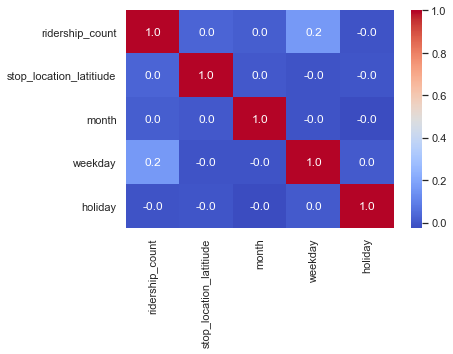

In [29]:
plot = sns.heatmap(result_df[['ridership_count', 'stop_location_latitiude', 'month', 'weekday', 'holiday', 'stop_name', 'zone']].corr(),
                   annot=True, fmt = ".1f", cmap='coolwarm');

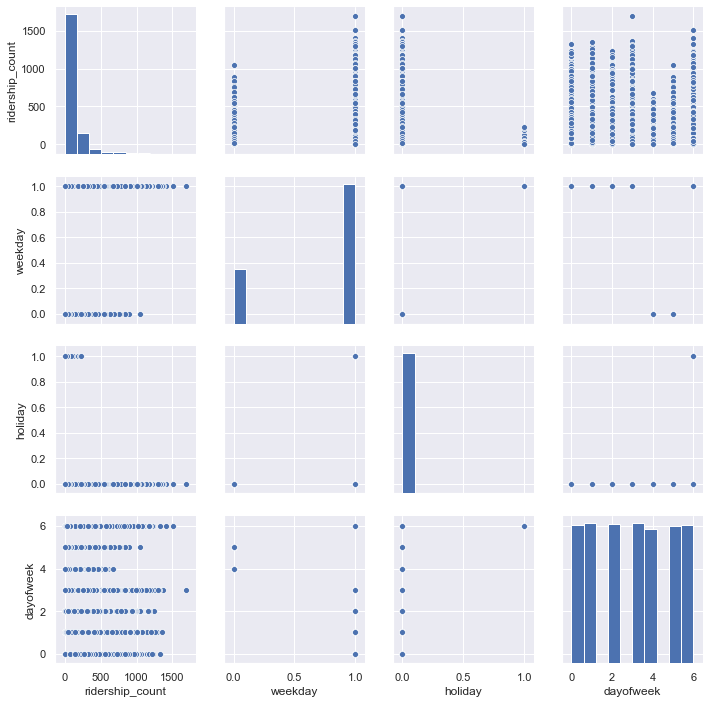

In [30]:
sns.pairplot(result_df, vars = ["ridership_count", 'weekday', 'holiday', 'dayofweek']);

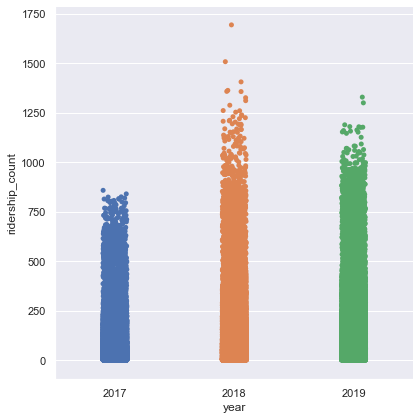

In [31]:
#Age / Survival correlation
sns.catplot(x='year', y='ridership_count', kind="strip", data=result_df, height=6);

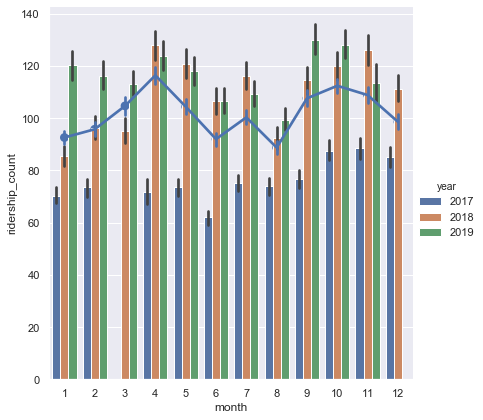

In [32]:
#Age / Survival correlation
sns.catplot(x='month', y='ridership_count', kind="bar", hue='year',data=result_df, height=6);
sns.pointplot(x='month', y='ridership_count', kind="point", data=result_df, height=6);

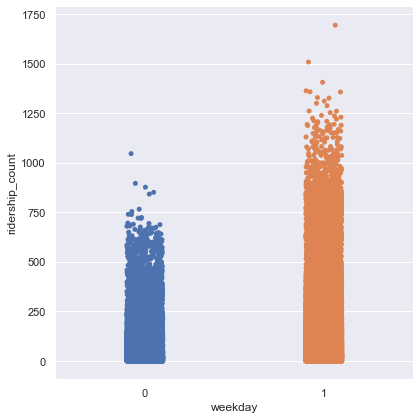

In [33]:
#Age / Survival correlation
sns.catplot(x='weekday', y='ridership_count', kind="strip", data=result_df, height=6);

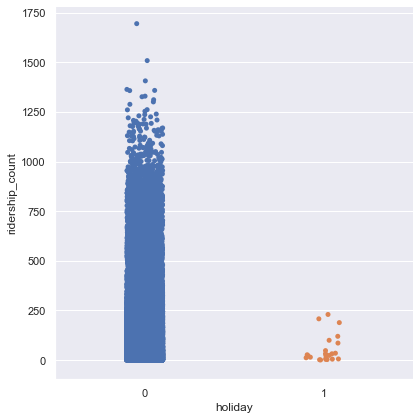

In [34]:
#Age / Survival correlation
sns.catplot(x='holiday', y='ridership_count', kind="strip", data=result_df, height=6);

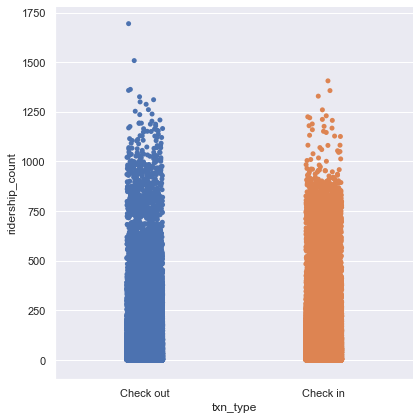

In [35]:
#Age / Survival correlation
sns.catplot(x='txn_type', y='ridership_count', kind="strip", data=result_df, height=6);

## Feature engineering on final data

In [36]:
def feature_engineering(df):
            
    print(df.shape)
    #Work on categorical data convert them to numerical values
    features_to_use = df.columns
    categorical = ['txn_type','stop_name', 'zone', 'Occasion']
    lencat=len(categorical)
    for c in categorical:
      if df[c].dtype == 'object':
        df[c] = df[c].astype('category')
        df[c] = df[c].cat.codes
    for c in features_to_use:
        if c not in categorical:
            df[c] = df[c].astype('float64')
    return df        

def one_hot_encoding(df, features):
    for f in features:
        df = pd.DataFrame(data=df, columns=['f'])
    return df

### Choosing the specific year data for learning/testing

In [37]:
train = result_df.loc[result_df['year'] != 2019]

train_X = train.drop('ridership_count', axis=1)
train_y = train['ridership_count']
train_X.shape

(67901, 29)

In [38]:
# df = train_X.copy()
train_X = feature_engineering(train_X)
# data = one_hot_encoding(data, cat_num_features)
train_X = pd.get_dummies(data=train_X, columns=['holidayDuration','Occasion', 'day','dayofweek', 'month', 'stop_name', 'txn_type', 'weekday',
                    'year','zone', 'holiday'])
train_X.head(2)

(67901, 29)


,DewAvg,DewMax,DewMin,HumidityAvg,HumidityMax,HumidityMin,Precipitation,PressureAvg,PressureMax,PressureMin,...,weekday_1.0,year_2017.0,year_2018.0,zone_0,zone_1,zone_2,zone_3,zone_4,holiday_0.0,holiday_1.0
0,63.5,66.0,61.0,75.3,88.0,58.0,0.0,30.0,30.0,30.0,...,1,1,0,0,0,0,0,1,0,1
1,63.5,66.0,61.0,75.3,88.0,58.0,0.0,30.0,30.0,30.0,...,1,1,0,0,0,0,1,0,0,1


### Split the data into train/test based on TimeSeriesSplit()

In [ ]:
# # Split the data for training and test/validation using TimeSeriesSplit
# tscv = TimeSeriesSplit()
# for train_index, test_index in tscv.split(train_X):
#     train_data, vald_data = train_X.iloc[train_index], train_X.iloc[test_index]
#     train_labels, vald_labels = train_y.iloc[train_index], train_y.iloc[test_index]
    
# for train_index, test_index in tscv.split(vald_data):
#     train_vald_data, test_vald_data = vald_data.iloc[train_index], vald_data.iloc[test_index]
#     train_vald_labels, test_vald_labels = vald_labels.iloc[train_index], vald_labels.iloc[test_index]

### Scaling of the data: StandardScaler

In [39]:
scaler = preprocessing.StandardScaler()
train_X = scaler.fit_transform(train_X)

In [ ]:
# Used with TimeSeriesSplit
# scaler = preprocessing.StandardScaler()
# train_data = scaler.fit_transform(train_data)

# train_vald_data = scaler.transform(train_vald_data)
# test_vald_data = scaler.transform(test_vald_data)

## Split the data into train/test

In [40]:
# Split the data for training and test/validation using TimeSeriesSplit
train_data, vald_data, train_labels, vald_labels = train_test_split(train_X, train_y, test_size=test_size, random_state=seed)

train_vald_data, test_vald_data, train_vald_labels, test_vald_labels = train_test_split(vald_data, vald_labels, test_size=test_size, random_state=seed)

In [ ]:
# scaler = preprocessing.StandardScaler()
# train_data = scaler.fit_transform(train_data)

# train_vald_data = scaler.transform(train_vald_data)
# test_vald_data = scaler.transform(test_vald_data)

### Do some EDA on the data to get some insight

**Comparing Machine Algorithms**

In [41]:
#Prepare the models
models =[]
# models.append(('LR', LinearRegression()))
models.append(('RG', Ridge()))
models.append(('LS', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('XGB', xgb.XGBRegressor(objective="reg:squarederror")))
models.append(('LGB', lgb.LGBMRegressor()))
# models.append(('SVM', SVR()))
results = []
names = []

RG: -9529.021192: (429.036699)
LS: -9586.893199: (446.699022)
EN: -10214.318458: (548.375016)
KNN: -7997.921354: (422.142781)
CART: -2126.445235: (201.141621)
XGB: -5245.357009: (176.854092)
LGB: -1310.076320: (114.830180)


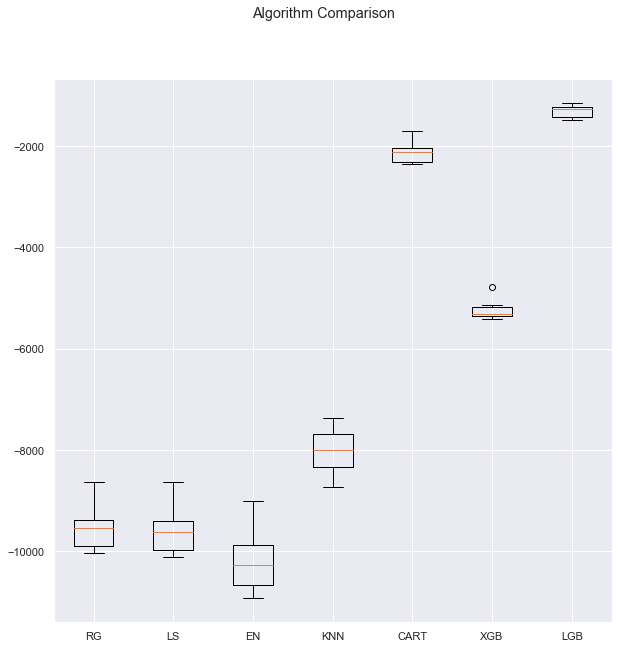

In [42]:
for name, model in models:
  kfold = KFold(n_splits=num_folds, random_state=seed )
  cv_results = cross_val_score(model, train_data, train_labels, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f: (%f)" % (name, cv_results.mean(), cv_results.std() )
  print(msg)
  
fig = plt.figure(figsize=(10,10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
# LR: -7569.622050: (1038.580639)
# RG: -7569.830348: (1038.906027)
# LS: -7600.289698: (1074.513775)
# EN: -7951.683308: (1139.804403)
# KNN: -7132.711578: (1007.018603)
# CART: -1714.933392: (1020.072988)
# LGB: -980.812200: (329.731635)


# Latest after feature scaling
# RG: -5408.131264: (332.492033)
# LS: -5454.829732: (341.586952)
# EN: -5854.590175: (457.226918)
# KNN: -4900.900050: (519.613268)
# CART: -975.540076: (72.569842)
# XGB: -2522.115962: (106.309839)
# LGB: -521.051262: (41.367971)

**Automated Workflow using Pipeline - Comparing Algorithm**

In [ ]:
i=0
results = []
for name, model in models:
  estimators = []
  estimators.append(('standaridge', preprocessing.StandardScaler()))
  estimators.append(models[i])
  modelPipeline = Pipeline(estimators)
  cv_results = cross_val_score(modelPipeline, train_data, train_labels, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  print("%s %f %f" % (name, cv_results.mean(), cv_results.std()))
  i += 1

## Create XGB model

### XGB parameters tuning(Using RandomizedSearch)

In [ ]:
# for tuning parameters
parameters_for_testing = {
   'colsample_bytree':[0.4,0.6,0.8],
   'gamma':[0,0.03,0.1,0.3],
   'min_child_weight':[1.5,6,10],
   'learning_rate':[0.1,0.07],
   'max_depth':[5,10],
   'n_estimators':[1000],
   'reg_alpha':[1e-5, 1e-2,  0.75],
   'reg_lambda':[1e-5, 1e-2, 0.45],
   'subsample':[0.6,0.95]  
}

                    
xgb_model = xgb.XGBRegressor(learning_rate =0.1, n_estimators=1000, max_depth=5,
    min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=6, scale_pos_weight=1, seed=1)

gsearch1 = RandomizedSearchCV(estimator = xgb_model, param_distributions = parameters_for_testing, n_jobs=6,iid=False, verbose=10,scoring='neg_mean_squared_error')
gsearch1.fit(train_data,train_labels)
print('best params')
print (gsearch1.best_params_)
print('best score')
print (gsearch1.best_score_)

In [44]:
def modelDef_cross_validation(train_data, train_labels, test_data, test_labels):

# Initial parameters:
#     param = {}
#     param['booster']='gbtree'
#     param['objective'] = 'reg:squarederror'
#     param['bst:eta'] = 0.04
#     param['seed']=  1
#     param['bst:max_depth'] = 6
#     param['bst:min_child_weight']= 1.
#     param['silent'] =  1  
#     param['nthread'] = 12 # put more if you have
#     param['bst:subsample'] = 0.7
#     param['eval_metric'] = 'rmse'
#     param['gamma'] = 1.0
#     param['colsample_bytree']= 1.0
#     param['num_parallel_tree']= 3   
#     param['colsample_bylevel']= 0.7                  
#     param['lambda']=5  

# Parameters set after running RandomizedSearchCV
    param = {}
    param['booster']='gbtree'
    param['objective'] = 'reg:squarederror'
    param['bst:eta'] = 0.07
    param['seed']=  1
    param['bst:max_depth'] = 5
    param['bst:min_child_weight']= 10.
    param['silent'] =  1  
    param['nthread'] = 12 # put more if you have
    param['bst:subsample'] = 0.95
    param['eval_metric'] = 'rmse'
    param['gamma'] = 0.1
    param['colsample_bytree']= 0.8
    param['num_parallel_tree']= 3   
    param['colsample_bylevel']= 0.7                  
    param['lambda']=5  
    param['reg_lambda']=0.01
    param['reg_alpha']=1e-05

#     {'subsample': 0.95, 'reg_lambda': 0.45, 'reg_alpha': 1e-05, 'n_estimators': 1000, 'min_child_weight': 10, 
#      'max_depth': 10, 'learning_rate': 0.07, 'gamma': 0.3, 'colsample_bytree': 0.6}
# -1162.2006688673953}

# {'subsample': 0.95, 'reg_lambda': 0.01, 'reg_alpha': 1e-05, 'n_estimators': 1000, 'min_child_weight': 10, 'max_depth': 5, 
#     'learning_rate': 0.07, 'gamma': 0.1, 'colsample_bytree': 0.8}
# best score
# -415.8296725435786

# With TimeSeriesSplit
# {'subsample': 0.95, 'reg_lambda': 0.45, 'reg_alpha': 1e-05, 'n_estimators': 1000, 'min_child_weight': 6, 'max_depth': 5, 
#  'learning_rate': 0.07, 'gamma': 0.1, 'colsample_bytree': 0.8}
# best score
# -650.1884262292104
    xg_train = xgb.DMatrix(data=train_data, label=train_labels)
    xg_test  = xgb.DMatrix(data=test_data, label=test_labels)
    cv_results = xgb.cv(dtrain=xg_train, params=param, nfold=5, num_boost_round=300,early_stopping_rounds=20,metrics="rmse", as_pandas=True,
                        seed=seed, verbose_eval=True)
    print(cv_results.mean(), cv_results.std())    
    
    watchlist = [ (xg_train,'train'), (xg_test, 'test') ]
    #Training the model on training data to be used for predictions
    print(train_data.shape, train_labels.shape)
    print("trainging of the model started - sit tight and relax")
    xgb_clf = xgb.train(param, xg_train, num_boost_round=300, evals=watchlist, early_stopping_rounds=20, verbose_eval=True)
    
    return param, xgb_clf
#     return param

In [43]:
def final_modelDef_training(param, train_data, train_labels):

    xg_train = xgb.DMatrix(data=train_data, label=train_labels)
    #Training the model on training data to be used for predictions
    print(train_data.shape, train_labels.shape)
    print("trainging of the model started - sit tight and relax")
    xgb_clf = xgb.train(param, xg_train, num_boost_round=130, verbose_eval=True)
    
    return xgb_clf

In [45]:
def model_test(param, model, vald_data, vald_labels):
    xgVald = xgb.DMatrix(vald_data)
    pred_y = model.predict(xgVald)    
    mean_square_error = mean_squared_error(vald_labels, pred_y)
    mean_abs_error = mean_absolute_error(test_vald_labels, pred_y)
    print("mean_square_error:", mean_square_error)
    print("mean_abs_error:", mean_abs_error)

    return pred_y, mean_square_error

In [46]:
#Define and train model 
param, xgb_clf = modelDef_cross_validation(train_data, train_labels, train_vald_data, train_vald_labels)

# param = modelDef_cross_validation(train_data, train_labels, train_vald_data, train_vald_labels)
# Stopping. Best iteration:
# [192]	train-rmse:11.4633	test-rmse:19.8807

[0]	train-rmse:123.211+0.495604	test-rmse:123.434+2.91948
[1]	train-rmse:101.534+0.822446	test-rmse:101.938+2.6668
[2]	train-rmse:87.6795+0.438471	test-rmse:88.3432+2.29158
[3]	train-rmse:79.5138+0.618678	test-rmse:80.3489+1.48436
[4]	train-rmse:73.9063+0.607551	test-rmse:74.7556+1.41523
[5]	train-rmse:69.4207+0.967334	test-rmse:70.281+2.25401
[6]	train-rmse:66.378+0.91542	test-rmse:67.3221+1.67648
[7]	train-rmse:63.4356+0.712747	test-rmse:64.4145+1.61015
[8]	train-rmse:61.7414+0.671011	test-rmse:62.8655+1.71886
[9]	train-rmse:60.4609+1.0525	test-rmse:61.6725+1.6971
[10]	train-rmse:59.297+1.06729	test-rmse:60.5997+1.40394
[11]	train-rmse:58.3239+1.28374	test-rmse:59.7173+1.25901
[12]	train-rmse:57.353+1.29223	test-rmse:58.8252+1.30857
[13]	train-rmse:56.4328+1.35676	test-rmse:57.985+1.30541
[14]	train-rmse:55.3362+1.50666	test-rmse:56.973+1.57609
[15]	train-rmse:54.6931+1.66542	test-rmse:56.3585+1.38223
[16]	train-rmse:54.3259+1.71505	test-rmse:56.0348+1.3373
[17]	train-rmse:53.7695+1.

[140]	train-rmse:23.1015+0.364667	test-rmse:31.5585+1.19943
[141]	train-rmse:23.0474+0.369346	test-rmse:31.5503+1.18788
[142]	train-rmse:22.9835+0.364732	test-rmse:31.5321+1.19112
[143]	train-rmse:22.9144+0.349232	test-rmse:31.5156+1.19754
[144]	train-rmse:22.8381+0.360476	test-rmse:31.4918+1.20084
[145]	train-rmse:22.7947+0.365529	test-rmse:31.4798+1.20209
[146]	train-rmse:22.7453+0.379049	test-rmse:31.4615+1.18275
[147]	train-rmse:22.6358+0.405138	test-rmse:31.4014+1.1429
[148]	train-rmse:22.5924+0.40806	test-rmse:31.3905+1.13804
[149]	train-rmse:22.5333+0.41341	test-rmse:31.3778+1.13625
[150]	train-rmse:22.4947+0.415144	test-rmse:31.3719+1.13717
[151]	train-rmse:22.4476+0.422492	test-rmse:31.364+1.13991
[152]	train-rmse:22.4003+0.431033	test-rmse:31.3458+1.1357
[153]	train-rmse:22.3494+0.436203	test-rmse:31.3309+1.12809
[154]	train-rmse:22.3027+0.438072	test-rmse:31.3294+1.12599
[155]	train-rmse:22.204+0.406476	test-rmse:31.2862+1.12576
[156]	train-rmse:22.1313+0.377981	test-rmse:31

Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 20 rounds.
[1]	train-rmse:101.524	test-rmse:103.039
[2]	train-rmse:87.0728	test-rmse:88.7441
[3]	train-rmse:78.6766	test-rmse:80.5144
[4]	train-rmse:74.1871	test-rmse:76.1824
[5]	train-rmse:68.8234	test-rmse:71.0441
[6]	train-rmse:66.1802	test-rmse:68.5127
[7]	train-rmse:63.7836	test-rmse:66.3832
[8]	train-rmse:62.5505	test-rmse:65.2181
[9]	train-rmse:61.4951	test-rmse:64.1135
[10]	train-rmse:60.5609	test-rmse:63.1996
[11]	train-rmse:60.0489	test-rmse:62.6952
[12]	train-rmse:59.0517	test-rmse:61.767
[13]	train-rmse:58.1897	test-rmse:61.0432
[14]	train-rmse:57.5937	test-rmse:60.4559
[15]	train-rmse:56.0484	test-rmse:59.0968
[16]	train-rmse:55.8112	test-rmse:58.8731
[17]	train-rmse:54.8807	test-rmse:57.996
[18]	train-rmse:54.4982	test-rmse:57.6557
[19]	train-rmse:54.0286	test-rmse:57.2591
[20]	train-rmse:53.2743	test-rmse:56.67
[21]	train-rmse:52.8941	test-r

[192]	train-rmse:21.4108	test-rmse:32.8691
[193]	train-rmse:21.3813	test-rmse:32.8483
[194]	train-rmse:21.3396	test-rmse:32.8366
[195]	train-rmse:21.2946	test-rmse:32.8048
[196]	train-rmse:21.2459	test-rmse:32.8007
[197]	train-rmse:21.1641	test-rmse:32.8276
[198]	train-rmse:21.1282	test-rmse:32.8309
[199]	train-rmse:21.0715	test-rmse:32.8152
[200]	train-rmse:21.0443	test-rmse:32.8179
[201]	train-rmse:21.0133	test-rmse:32.8158
[202]	train-rmse:20.9756	test-rmse:32.8221
[203]	train-rmse:20.9245	test-rmse:32.8075
[204]	train-rmse:20.8698	test-rmse:32.8221
[205]	train-rmse:20.838	test-rmse:32.8373
[206]	train-rmse:20.7924	test-rmse:32.8418
[207]	train-rmse:20.7381	test-rmse:32.8546
[208]	train-rmse:20.6878	test-rmse:32.8491
[209]	train-rmse:20.6594	test-rmse:32.8469
[210]	train-rmse:20.6541	test-rmse:32.8462
[211]	train-rmse:20.6432	test-rmse:32.842
[212]	train-rmse:20.6159	test-rmse:32.8427
[213]	train-rmse:20.5886	test-rmse:32.8442
[214]	train-rmse:20.5571	test-rmse:32.8405
[215]	train-r

In [47]:
pred_y, mean_square_error = model_test(param, xgb_clf, test_vald_data, test_vald_labels)

# After feature scaling on 2017 year data
# 373.39624275560595
# 368.93802376644584

mean_square_error: 823.5542219993482
mean_abs_error: 16.336839829717825


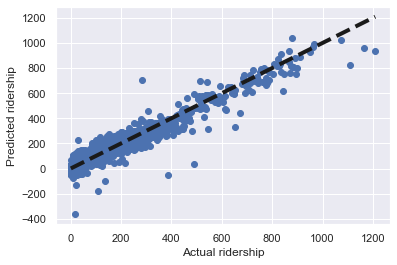

In [48]:
y = test_vald_labels
fig, ax = plt.subplots()
ax.scatter(y, pred_y)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Actual ridership')
ax.set_ylabel('Predicted ridership')
plt.show()

In [49]:
pd.set_option("display.max_rows", 100)
result = pd.DataFrame(test_vald_data)
result['actual_ridership'] = test_vald_labels.values
result['predicted_ridership'] = pred_y
result.tail(100)

,0,1,2,3,4,5,6,7,8,9,...,151,152,153,154,155,156,157,158,actual_ridership,predicted_ridership
6012,-0.012545,-0.279947,0.213952,-0.443065,-0.764574,-0.376343,0.0,-0.208876,-0.059916,0.069026,...,0.922973,-0.055164,-0.003838,-0.013295,0.889125,-0.883325,0.018804,-0.018804,29.0,47.307953
6013,0.478748,1.117569,-1.030341,0.073649,0.842108,-1.312448,0.0,0.177958,0.344775,0.112816,...,0.922973,-0.055164,-0.003838,-0.013295,-1.124701,1.132086,0.018804,-0.018804,59.0,58.191216
6014,-0.615495,-0.709952,-0.408194,-0.164834,-0.229013,-0.142316,0.0,0.564792,0.344775,0.112816,...,0.922973,-0.055164,-0.003838,-0.013295,0.889125,-0.883325,0.018804,-0.018804,52.0,77.929199
6015,0.690897,0.902566,0.391708,-0.888233,-0.688065,-0.532360,0.0,-0.982544,-0.869297,-0.018553,...,-1.083455,-0.055164,-0.003838,-0.013295,-1.124701,1.132086,0.018804,-0.018804,91.0,94.299591
6016,0.512245,1.117569,0.125074,-0.729245,1.224651,-0.844395,0.0,-0.982544,-0.869297,-0.018553,...,-1.083455,-0.055164,-0.003838,-0.013295,-1.124701,1.132086,0.018804,-0.018804,129.0,148.981949
6017,0.355925,0.472561,-0.674829,-0.951829,-0.994100,-1.312448,0.0,-0.982544,-0.869297,-0.062343,...,-1.083455,-0.055164,-0.003838,-0.013295,-1.124701,1.132086,0.018804,-0.018804,56.0,51.611176
6018,-0.101871,0.687564,-0.408194,-0.784891,0.153530,-0.922404,0.0,-0.595710,-0.464607,0.025236,...,-1.083455,-0.055164,-0.003838,-0.013295,0.889125,-0.883325,0.018804,-0.018804,106.0,79.087326
6019,-0.503838,-0.494949,0.213952,0.431374,0.383056,0.793789,0.0,0.177958,0.344775,0.112816,...,0.922973,-0.055164,-0.003838,-0.013295,0.889125,-0.883325,0.018804,-0.018804,33.0,46.926868
6020,0.646234,0.472561,0.747221,-1.166464,-1.835694,-0.688378,0.0,-1.369378,-1.273988,-0.062343,...,-1.083455,-0.055164,-0.003838,-0.013295,0.889125,-0.883325,0.018804,-0.018804,170.0,192.452835
6021,0.043284,-0.494949,0.747221,2.061009,1.530685,2.275956,0.0,0.951626,0.749465,0.200396,...,-1.083455,-0.055164,-0.003838,-0.013295,-1.124701,1.132086,0.018804,-0.018804,9.0,-29.857979


### XGB through sci-kit API

In [ ]:
model = xgb.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=1) 

In [ ]:
# model.fit(X_train,y_train)

In [ ]:
# OrderedDict(sorted(model.get_booster().get_fscore().items(), key=lambda t: t[1], reverse=True))

In [ ]:
# xgb.plot_importance(model.get_booster().get_fscore(), ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance',
#                         xlabel='F score', ylabel='Features', importance_type='coverage', max_num_features=15, grid=True, 
#                         show_values=True);

## lgb model 

### Grid Search lgb

In [ ]:
gridParams = {
    'learning_rate': [0.075, 0.07, 0.065],
    'n_estimators': [450, 500, 550],
    'num_leaves': [40,45,50], # large num_leaves helps improve accuracy but might lead to over-fitting
    'boosting_type' : ['gbdt', 'dart'], # for better accuracy -> try dart
    'objective' : ['regression', 'tweedie'],
    'max_bin':[40, 45, 50, 55, 60], # large max_bin helps improve accuracy but might slow down training progress
    'random_state' : [300, 400, 500, 600],
    'colsample_bytree' : [0.64, 0.65, 0.66, 0.67],
    'subsample' : [0.6, 0.65, 0.7, 0.75],
    'reg_alpha' : [0.55, 0.6, 0.65, 0.7],
    'reg_lambda' : [0.05, 0.08, 0.1, 0.15, 0.17],
    'max_depth': [18, 19, 20, 21, 23],
    'min_data_in_leaf': [30, 40, 50, 60, 70]
    }

# {'subsample': 0.7, 'reg_lambda': 1.2, 'reg_alpha': 1.2, 'random_state': 500, 'objective': 'regression', 'num_leaves': 12, 'n_estimators': 16, 'min_data_in_leaf': 100, 'max_depth': 20, 'max_bin': 500, 'learning_rate': 0.1, 'colsample_bytree': 0.64, 'boosting_type': 'dart'}
# 0.435305094518894

# {'subsample': 0.5, 'reg_lambda': 0.3, 'reg_alpha': 0.5, 'random_state': 100, 'objective': 'regression', 'num_leaves': 50,
# 'n_estimators': 500, 'min_data_in_leaf': 100, 'max_depth': 20, 'max_bin': 100, 'learning_rate': 0.07, 
# 'colsample_bytree': 0.64, 'boosting_type': 'gbdt'}
# -1157.563536940113

# {'subsample': 0.7, 'reg_lambda': 0.1, 'reg_alpha': 0.6, 'random_state': 500, 'objective': 'regression', 'num_leaves': 45, 
#  'n_estimators': 500, 'min_data_in_leaf': 50, 'max_depth': 20, 'max_bin': 50, 'learning_rate': 0.07, 'colsample_bytree': 0.65,
#  'boosting_type': 'gbdt'}
# -876.3049398569635

# {'subsample': 0.75, 'reg_lambda': 0.15, 'reg_alpha': 0.6, 'random_state': 400, 'objective': 'regression', 'num_leaves': 45, 'n_estimators': 500, 'min_data_in_leaf': 30, 'max_depth': 23, 'max_bin': 50, 'learning_rate': 0.075, 'colsample_bytree': 0.64, 'boosting_type': 'gbdt'}
# -692.4855750519663
model = lgb.LGBMRegressor(boosting_type= 'gbdt', 
          objective = 'tweedie', 
          n_estimators=1000,
          n_jobs = 6, 
          max_depth = -1,
          max_bin = 510, 
          subsample_for_bin = 200,
          subsample = 1, 
          min_split_gain = 0.5, 
          min_child_weight = 1, 
          min_child_samples = 5)

grid = RandomizedSearchCV(model, gridParams, verbose=1, cv=tss, n_jobs=-1, scoring='neg_mean_squared_error')
# Run the grid
grid.fit(train_data, train_labels)

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

In [ ]:
grid.best_params_
# {'subsample': 0.7, 'reg_lambda': 1.4, 'reg_alpha': 1, 'random_state': 500, 'objective': 'regression', 'num_leaves': 6, 'n_estimators': 24, 'max_bin': 255, 'learning_rate': 0.01, 'colsample_bytree': 0.66, 'boosting_type': 'gbdt'}
# 0.13676311446328027

### lgb model defenition

In [50]:
def lgb_modelDef_cross_validation(train_data, train_labels, test_data, test_labels):

# Initial parameters:
#     param = {}
#     param['booster']='gbtree'
#     param['objective'] = 'regression_l2'
#     param['bst:eta'] = 0.04
#     param['seed']=  1
#     param['bst:max_depth'] = 6
#     param['bst:min_child_weight']= 1.
#     param['nthread'] = 12 # put more if you have
#     param['bst:subsample'] = 0.7
#     param['eval_metric'] = 'rmse'
#     param['gamma'] = 1.0
#     param['colsample_bytree']= 1.0
#     param['num_parallel_tree']= 3   
#     param['colsample_bylevel']= 0.7                  
#     param['lambda']=5  

# Parameters after RandomSearchCV
    param = {
        'application': 'regression', # for regression
        'boosting': 'dart', # traditional gradient boosting decision tree
#         'num_iterations': 16, 
        'learning_rate': 0.075,
        'num_leaves': 45,
        'random_state': 400,
        'max_depth': 23, # <0 means no limit
        'max_bin': 50, # Small number of bins may reduce training accuracy but can deal with over-fitting
        'lambda_l1': 0.6, # L1 regularization
        'lambda_l2': 1.5, # L2 regularization
        'metric' : 'mse',
        'subsample_for_bin': 200, # number of samples for constructing bins
        'subsample': 0.75, # subsample ratio of the training instance
        'colsample_bytree': 0.64, # subsample ratio of columns when constructing the tree
        'min_split_gain': 0.5, # minimum loss reduction required to make further partition on a leaf node of the tree
        'min_child_weight': 1, # minimum sum of instance weight (hessian) needed in a leaf
        'min_child_samples': 5, # minimum number of data needed in a leaf,
        'min_data_in_leaf': 30
    }

    # {'subsample': 0.7, 'reg_lambda': 1.2, 'reg_alpha': 1.2, 'random_state': 500, 'objective': 'regression', 'num_leaves': 12,
    #     'n_estimators': 16, 'min_data_in_leaf': 100, 'max_depth': 20, 'max_bin': 500, 'learning_rate': 0.1,
    # 'colsample_bytree': 0.64, 'boosting_type': 'dart'}
    # 0.435305094518894
    
# {'subsample': 0.75, 'reg_lambda': 0.15, 'reg_alpha': 0.6, 'random_state': 400, 'objective': 'regression', 'num_leaves': 45,
# 'n_estimators': 500, 'min_data_in_leaf': 30, 'max_depth': 23, 'max_bin': 50, 'learning_rate': 0.075, 'colsample_bytree': 0.64,
# 'boosting_type': 'gbdt'} -692.4855750519663

    lg_train = lgb.Dataset(data=train_data, label=train_labels)
    lg_test  = lgb.Dataset(data=test_data, label=test_labels)
    cv_results = lgb.cv(param, lg_train, num_boost_round=2000, nfold=5, early_stopping_rounds=20,metrics="mse", seed=seed, verbose_eval=True)
    print(cv_results)    
    
    #Training the model on training data to be used for predictions
    print(train_data.shape, train_labels.shape)
    print("trainging of the model started - sit tight and relax")
    lgb_clf = lgb.train(param, lg_train, num_boost_round=2000, valid_sets=lg_test, early_stopping_rounds=20, verbose_eval=True)
    
    return param, lgb_clf

In [51]:
def lgb_model_test(param, model, vald_data, vald_labels):
#     lgVald = lgb.Dataset(vald_data)
    pred_y = model.predict(vald_data)    
    mean_square_error = mean_squared_error(vald_labels, pred_y)
    mean_abs_error = mean_absolute_error(test_vald_labels, pred_y)
    print("mean_square_error:", mean_square_error)
    print("mean_abs_error:", mean_abs_error)
    
    return pred_y, mean_square_error

In [52]:
#Define and train model 
lgb_param, lgb_clf = lgb_modelDef_cross_validation(train_data, train_labels, train_vald_data, train_vald_labels)

# param = modelDef_cross_validation(train_data, train_labels, train_vald_data, train_vald_labels)
# [500]	valid_0's l2: 517.048
# [1000]	valid_0's l2: 404.314
# [2000]	valid_0's l2: 385.031

C:\Users\amitj\AppData\Local\Continuum\anaconda3\envs\PythonGPU\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[1]	cv_agg's l2: 14225 + 714.136
[2]	cv_agg's l2: 12766.7 + 699.041
[3]	cv_agg's l2: 11844.8 + 652.999
[4]	cv_agg's l2: 10987.9 + 646.108
[5]	cv_agg's l2: 10875 + 612.963
[6]	cv_agg's l2: 10072.3 + 605.73
[7]	cv_agg's l2: 10043.4 + 596.387
[8]	cv_agg's l2: 9580.01 + 557.981
[9]	cv_agg's l2: 8719.6 + 518.001
[10]	cv_agg's l2: 8012.44 + 476.247


C:\Users\amitj\AppData\Local\Continuum\anaconda3\envs\PythonGPU\lib\site-packages\lightgbm\callback.py:192: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[11]	cv_agg's l2: 7921.73 + 468.132
[12]	cv_agg's l2: 8037.51 + 481.041
[13]	cv_agg's l2: 7286.87 + 442.435
[14]	cv_agg's l2: 6770.66 + 414.345
[15]	cv_agg's l2: 6300.44 + 386.293
[16]	cv_agg's l2: 5988.9 + 354.506
[17]	cv_agg's l2: 6106.12 + 361.936
[18]	cv_agg's l2: 5681.71 + 342.73
[19]	cv_agg's l2: 5268.11 + 319.214
[20]	cv_agg's l2: 5527 + 320.839
[21]	cv_agg's l2: 5666.74 + 325.632
[22]	cv_agg's l2: 5767.74 + 324.437
[23]	cv_agg's l2: 5487.81 + 317.647
[24]	cv_agg's l2: 5674.05 + 341.929
[25]	cv_agg's l2: 5629.75 + 344.67
[26]	cv_agg's l2: 5561.24 + 344.22
[27]	cv_agg's l2: 5334.86 + 323.254
[28]	cv_agg's l2: 5188.52 + 313.542
[29]	cv_agg's l2: 4973.48 + 305.115
[30]	cv_agg's l2: 4674.58 + 279.048
[31]	cv_agg's l2: 4411.42 + 266.21
[32]	cv_agg's l2: 4444.33 + 267.625
[33]	cv_agg's l2: 4156.09 + 267.906
[34]	cv_agg's l2: 3977.7 + 252.766
[35]	cv_agg's l2: 4069.59 + 261.103
[36]	cv_agg's l2: 3884.89 + 228.207
[37]	cv_agg's l2: 3725.01 + 214.615
[38]	cv_agg's l2: 3527.35 + 197.437
[

[238]	cv_agg's l2: 3009.87 + 937.921
[239]	cv_agg's l2: 3042.36 + 929.718
[240]	cv_agg's l2: 3006.78 + 937.845
[241]	cv_agg's l2: 3029.83 + 928.143
[242]	cv_agg's l2: 2999.44 + 933.579
[243]	cv_agg's l2: 3026.81 + 931.394
[244]	cv_agg's l2: 2999.56 + 938.237
[245]	cv_agg's l2: 2967.71 + 951.93
[246]	cv_agg's l2: 2949.28 + 955.157
[247]	cv_agg's l2: 2850.93 + 823.046
[248]	cv_agg's l2: 2878.13 + 814.287
[249]	cv_agg's l2: 2905.62 + 812.643
[250]	cv_agg's l2: 2955.03 + 808.276
[251]	cv_agg's l2: 2978.64 + 812.557
[252]	cv_agg's l2: 3008.6 + 800.581
[253]	cv_agg's l2: 2983.93 + 802.809
[254]	cv_agg's l2: 2948.09 + 819.682
[255]	cv_agg's l2: 2930.6 + 823.447
[256]	cv_agg's l2: 2838.56 + 698.207
[257]	cv_agg's l2: 2758.73 + 600.613
[258]	cv_agg's l2: 2710.54 + 560.898
[259]	cv_agg's l2: 2689.36 + 573.202
[260]	cv_agg's l2: 2670.63 + 585.083
[261]	cv_agg's l2: 2689.05 + 581.283
[262]	cv_agg's l2: 2671.33 + 590.292
[263]	cv_agg's l2: 2693.82 + 592.302
[264]	cv_agg's l2: 2718.65 + 599.432
[265

[462]	cv_agg's l2: 1872.47 + 302.867
[463]	cv_agg's l2: 1883.61 + 304.504
[464]	cv_agg's l2: 1897.17 + 306.445
[465]	cv_agg's l2: 1891.03 + 308.974
[466]	cv_agg's l2: 1884.7 + 312.166
[467]	cv_agg's l2: 1896 + 313.67
[468]	cv_agg's l2: 1891.21 + 315.357
[469]	cv_agg's l2: 1902.22 + 316.292
[470]	cv_agg's l2: 1898.4 + 317.237
[471]	cv_agg's l2: 1872.4 + 315.125
[472]	cv_agg's l2: 1880.16 + 314.887
[473]	cv_agg's l2: 1891.81 + 316.561
[474]	cv_agg's l2: 1887 + 322.004
[475]	cv_agg's l2: 1897.99 + 323.263
[476]	cv_agg's l2: 1893.24 + 324.457
[477]	cv_agg's l2: 1902.79 + 324.509
[478]	cv_agg's l2: 1893.35 + 333.788
[479]	cv_agg's l2: 1903.4 + 334.919
[480]	cv_agg's l2: 1913.96 + 336.335
[481]	cv_agg's l2: 1897.67 + 344.892
[482]	cv_agg's l2: 1881.98 + 355.568
[483]	cv_agg's l2: 1896.06 + 356.936
[484]	cv_agg's l2: 1905.67 + 357.308
[485]	cv_agg's l2: 1921.02 + 358.924
[486]	cv_agg's l2: 1905.17 + 368.144
[487]	cv_agg's l2: 1896.59 + 373.846
[488]	cv_agg's l2: 1887.47 + 377.758
[489]	cv_agg

[685]	cv_agg's l2: 1392.55 + 180.67
[686]	cv_agg's l2: 1387.04 + 180.101
[687]	cv_agg's l2: 1392.41 + 179.853
[688]	cv_agg's l2: 1398.11 + 179.392
[689]	cv_agg's l2: 1389.61 + 181.021
[690]	cv_agg's l2: 1383.89 + 182.996
[691]	cv_agg's l2: 1388.23 + 182.9
[692]	cv_agg's l2: 1383.69 + 184.535
[693]	cv_agg's l2: 1389.19 + 184.323
[694]	cv_agg's l2: 1385.75 + 185.459
[695]	cv_agg's l2: 1391 + 185.165
[696]	cv_agg's l2: 1396.42 + 184.879
[697]	cv_agg's l2: 1404.03 + 185.16
[698]	cv_agg's l2: 1412.74 + 185.789
[699]	cv_agg's l2: 1406.61 + 187.661
[700]	cv_agg's l2: 1403.07 + 187.382
[701]	cv_agg's l2: 1399.06 + 188.669
[702]	cv_agg's l2: 1394.13 + 190.481
[703]	cv_agg's l2: 1399.12 + 191.09
[704]	cv_agg's l2: 1405.46 + 190.77
[705]	cv_agg's l2: 1409.73 + 190.113
[706]	cv_agg's l2: 1416.01 + 191.546
[707]	cv_agg's l2: 1412.03 + 192.123
[708]	cv_agg's l2: 1407.86 + 193.637
[709]	cv_agg's l2: 1402.95 + 197.05
[710]	cv_agg's l2: 1408.59 + 196.678
[711]	cv_agg's l2: 1414.37 + 196.303
[712]	cv_ag

[909]	cv_agg's l2: 1424.17 + 308.356
[910]	cv_agg's l2: 1422.48 + 308.686
[911]	cv_agg's l2: 1418.28 + 311.744
[912]	cv_agg's l2: 1424.3 + 313.243
[913]	cv_agg's l2: 1430.87 + 315.254
[914]	cv_agg's l2: 1436.65 + 318.001
[915]	cv_agg's l2: 1431 + 321.466
[916]	cv_agg's l2: 1435.47 + 323.069
[917]	cv_agg's l2: 1439.76 + 324.346
[918]	cv_agg's l2: 1437.32 + 325.852
[919]	cv_agg's l2: 1441.06 + 326.329
[920]	cv_agg's l2: 1445.57 + 328.078
[921]	cv_agg's l2: 1452.51 + 330.166
[922]	cv_agg's l2: 1457.53 + 331.888
[923]	cv_agg's l2: 1454.34 + 332.631
[924]	cv_agg's l2: 1445.11 + 335.957
[925]	cv_agg's l2: 1443.63 + 336.192
[926]	cv_agg's l2: 1440.53 + 338.736
[927]	cv_agg's l2: 1438.08 + 339.849
[928]	cv_agg's l2: 1426.34 + 343.827
[929]	cv_agg's l2: 1430.94 + 345.319
[930]	cv_agg's l2: 1435.83 + 347.283
[931]	cv_agg's l2: 1433.5 + 347.556
[932]	cv_agg's l2: 1439.58 + 349.327
[933]	cv_agg's l2: 1444.16 + 350.816
[934]	cv_agg's l2: 1432.95 + 357.727
[935]	cv_agg's l2: 1425.7 + 360.53
[936]	cv

[1130]	cv_agg's l2: 1427.2 + 514.216
[1131]	cv_agg's l2: 1429.64 + 513.917
[1132]	cv_agg's l2: 1425.05 + 516.216
[1133]	cv_agg's l2: 1423.08 + 516.466
[1134]	cv_agg's l2: 1426.56 + 517.229
[1135]	cv_agg's l2: 1424.29 + 518.314
[1136]	cv_agg's l2: 1426.61 + 518.349
[1137]	cv_agg's l2: 1424.1 + 519.434
[1138]	cv_agg's l2: 1427.07 + 521.031
[1139]	cv_agg's l2: 1424.75 + 521.295
[1140]	cv_agg's l2: 1421.3 + 524.465
[1141]	cv_agg's l2: 1419.78 + 524.94
[1142]	cv_agg's l2: 1418.47 + 525.49
[1143]	cv_agg's l2: 1417.24 + 525.896
[1144]	cv_agg's l2: 1419.74 + 526.496
[1145]	cv_agg's l2: 1418.86 + 527.684
[1146]	cv_agg's l2: 1417.89 + 528.489
[1147]	cv_agg's l2: 1420.54 + 529.247
[1148]	cv_agg's l2: 1423.39 + 530.878
[1149]	cv_agg's l2: 1428.39 + 533.07
[1150]	cv_agg's l2: 1431.14 + 533.96
[1151]	cv_agg's l2: 1433.31 + 534.41
[1152]	cv_agg's l2: 1431.62 + 534.704
[1153]	cv_agg's l2: 1434.87 + 535.694
[1154]	cv_agg's l2: 1437.38 + 536.051
[1155]	cv_agg's l2: 1435.87 + 536.876
[1156]	cv_agg's l2: 

[1350]	cv_agg's l2: 1303.01 + 352.438
[1351]	cv_agg's l2: 1304.96 + 352.895
[1352]	cv_agg's l2: 1303.87 + 353.292
[1353]	cv_agg's l2: 1301.46 + 355.053
[1354]	cv_agg's l2: 1303.67 + 355.897
[1355]	cv_agg's l2: 1302.8 + 356.269
[1356]	cv_agg's l2: 1302.28 + 355.994
[1357]	cv_agg's l2: 1301.33 + 356.148
[1358]	cv_agg's l2: 1300.95 + 356.522
[1359]	cv_agg's l2: 1299.91 + 356.903
[1360]	cv_agg's l2: 1299.38 + 357.874
[1361]	cv_agg's l2: 1301.06 + 358.554
[1362]	cv_agg's l2: 1303.42 + 359.31
[1363]	cv_agg's l2: 1294.83 + 352.67
[1364]	cv_agg's l2: 1293.06 + 354.34
[1365]	cv_agg's l2: 1295 + 354.804
[1366]	cv_agg's l2: 1287.01 + 350.376
[1367]	cv_agg's l2: 1289.07 + 351.144
[1368]	cv_agg's l2: 1288.71 + 351.289
[1369]	cv_agg's l2: 1290.56 + 351.289
[1370]	cv_agg's l2: 1289.61 + 352.257
[1371]	cv_agg's l2: 1287.11 + 354.289
[1372]	cv_agg's l2: 1289.55 + 354.712
[1373]	cv_agg's l2: 1289.22 + 355.03
[1374]	cv_agg's l2: 1288.04 + 355.53
[1375]	cv_agg's l2: 1287.74 + 355.682
[1376]	cv_agg's l2: 1

[1567]	cv_agg's l2: 1203.45 + 239.475
[1568]	cv_agg's l2: 1205.31 + 239.632
[1569]	cv_agg's l2: 1203.03 + 240.243
[1570]	cv_agg's l2: 1200.29 + 241.375
[1571]	cv_agg's l2: 1197.46 + 242.606
[1572]	cv_agg's l2: 1195.75 + 242.563
[1573]	cv_agg's l2: 1196.92 + 242.305
[1574]	cv_agg's l2: 1195.07 + 242.398
[1575]	cv_agg's l2: 1196.84 + 242.728
[1576]	cv_agg's l2: 1195.54 + 243.014
[1577]	cv_agg's l2: 1198.25 + 243.524
[1578]	cv_agg's l2: 1195.19 + 244.949
[1579]	cv_agg's l2: 1196.87 + 245.19
[1580]	cv_agg's l2: 1194.99 + 246.094
[1581]	cv_agg's l2: 1196.58 + 246.159
[1582]	cv_agg's l2: 1198.4 + 246.046
[1583]	cv_agg's l2: 1196.9 + 246.586
[1584]	cv_agg's l2: 1196.41 + 246.431
[1585]	cv_agg's l2: 1198.59 + 246.893
[1586]	cv_agg's l2: 1198.24 + 246.887
[1587]	cv_agg's l2: 1197.61 + 246.754
[1588]	cv_agg's l2: 1199.55 + 246.923
[1589]	cv_agg's l2: 1201.05 + 247.199
[1590]	cv_agg's l2: 1198.35 + 249.063
[1591]	cv_agg's l2: 1200.22 + 249.31
[1592]	cv_agg's l2: 1202.15 + 249.838
[1593]	cv_agg's 

[1787]	cv_agg's l2: 1105.46 + 157.818
[1788]	cv_agg's l2: 1107.35 + 158.065
[1789]	cv_agg's l2: 1104.78 + 154.874
[1790]	cv_agg's l2: 1103.75 + 153.688
[1791]	cv_agg's l2: 1100.59 + 149.252
[1792]	cv_agg's l2: 1098.99 + 147.023
[1793]	cv_agg's l2: 1097.39 + 145.417
[1794]	cv_agg's l2: 1098.74 + 145.355
[1795]	cv_agg's l2: 1099.88 + 145.473
[1796]	cv_agg's l2: 1101.17 + 145.326
[1797]	cv_agg's l2: 1100.97 + 145.262
[1798]	cv_agg's l2: 1102.15 + 145.04
[1799]	cv_agg's l2: 1103.46 + 145.018
[1800]	cv_agg's l2: 1104.76 + 145.391
[1801]	cv_agg's l2: 1101.53 + 146.065
[1802]	cv_agg's l2: 1102.69 + 145.832
[1803]	cv_agg's l2: 1099.92 + 146.379
[1804]	cv_agg's l2: 1096.27 + 148.416
[1805]	cv_agg's l2: 1097.86 + 148.159
[1806]	cv_agg's l2: 1096.61 + 148.385
[1807]	cv_agg's l2: 1098.07 + 148.597
[1808]	cv_agg's l2: 1099.41 + 148.536
[1809]	cv_agg's l2: 1100.4 + 148.076
[1810]	cv_agg's l2: 1101.69 + 147.755
[1811]	cv_agg's l2: 1100.65 + 148.016
[1812]	cv_agg's l2: 1098.13 + 148.997
[1813]	cv_agg'

[16]	valid_0's l2: 6247.01
[17]	valid_0's l2: 6374.4
[18]	valid_0's l2: 5915.17
[19]	valid_0's l2: 5488.87
[20]	valid_0's l2: 5744.75
[21]	valid_0's l2: 5881.12
[22]	valid_0's l2: 5943.16
[23]	valid_0's l2: 5668.83
[24]	valid_0's l2: 5846.44
[25]	valid_0's l2: 5809.8
[26]	valid_0's l2: 5720.92
[27]	valid_0's l2: 5501.87
[28]	valid_0's l2: 5349.31
[29]	valid_0's l2: 5246.16
[30]	valid_0's l2: 5137.57
[31]	valid_0's l2: 4847.56
[32]	valid_0's l2: 4893.98
[33]	valid_0's l2: 4587.85
[34]	valid_0's l2: 4371.41
[35]	valid_0's l2: 4466.92
[36]	valid_0's l2: 4226.61
[37]	valid_0's l2: 4054.47
[38]	valid_0's l2: 3823.32
[39]	valid_0's l2: 3876.76
[40]	valid_0's l2: 3933.93
[41]	valid_0's l2: 3863.27
[42]	valid_0's l2: 3794.68
[43]	valid_0's l2: 3859.59
[44]	valid_0's l2: 4175.96
[45]	valid_0's l2: 4090.02
[46]	valid_0's l2: 4203.23
[47]	valid_0's l2: 4114.46
[48]	valid_0's l2: 4036.11
[49]	valid_0's l2: 4362.98
[50]	valid_0's l2: 4453.62
[51]	valid_0's l2: 4512.13
[52]	valid_0's l2: 4608.28
[53

[315]	valid_0's l2: 2161.95
[316]	valid_0's l2: 2180.82
[317]	valid_0's l2: 2198.06
[318]	valid_0's l2: 2120.81
[319]	valid_0's l2: 2143.87
[320]	valid_0's l2: 2105.22
[321]	valid_0's l2: 2118.51
[322]	valid_0's l2: 2137.21
[323]	valid_0's l2: 2058.89
[324]	valid_0's l2: 2080.99
[325]	valid_0's l2: 2046.26
[326]	valid_0's l2: 2067.17
[327]	valid_0's l2: 2091.34
[328]	valid_0's l2: 2017.28
[329]	valid_0's l2: 1937.42
[330]	valid_0's l2: 1953.42
[331]	valid_0's l2: 1912.47
[332]	valid_0's l2: 1883.28
[333]	valid_0's l2: 1873.52
[334]	valid_0's l2: 1891.41
[335]	valid_0's l2: 1904.11
[336]	valid_0's l2: 1921.54
[337]	valid_0's l2: 1952.61
[338]	valid_0's l2: 1938.92
[339]	valid_0's l2: 1956.87
[340]	valid_0's l2: 1979.55
[341]	valid_0's l2: 1998.3
[342]	valid_0's l2: 2017.24
[343]	valid_0's l2: 2039.33
[344]	valid_0's l2: 1971.62
[345]	valid_0's l2: 1990.26
[346]	valid_0's l2: 1956.72
[347]	valid_0's l2: 1894.24
[348]	valid_0's l2: 1857.75
[349]	valid_0's l2: 1831.76
[350]	valid_0's l2: 1

[609]	valid_0's l2: 2059.33
[610]	valid_0's l2: 2068.93
[611]	valid_0's l2: 1993.71
[612]	valid_0's l2: 2001.96
[613]	valid_0's l2: 2012.72
[614]	valid_0's l2: 1925.91
[615]	valid_0's l2: 1854.49
[616]	valid_0's l2: 1861.05
[617]	valid_0's l2: 1855.69
[618]	valid_0's l2: 1864.67
[619]	valid_0's l2: 1794.79
[620]	valid_0's l2: 1802.96
[621]	valid_0's l2: 1809.58
[622]	valid_0's l2: 1816.12
[623]	valid_0's l2: 1769.45
[624]	valid_0's l2: 1775.99
[625]	valid_0's l2: 1736.82
[626]	valid_0's l2: 1743.25
[627]	valid_0's l2: 1752.04
[628]	valid_0's l2: 1757.21
[629]	valid_0's l2: 1728.6
[630]	valid_0's l2: 1723.5
[631]	valid_0's l2: 1719.41
[632]	valid_0's l2: 1728.04
[633]	valid_0's l2: 1723.21
[634]	valid_0's l2: 1729.61
[635]	valid_0's l2: 1737.18
[636]	valid_0's l2: 1733.3
[637]	valid_0's l2: 1744.03
[638]	valid_0's l2: 1740.78
[639]	valid_0's l2: 1735.86
[640]	valid_0's l2: 1731.83
[641]	valid_0's l2: 1728.17
[642]	valid_0's l2: 1734.26
[643]	valid_0's l2: 1740.46
[644]	valid_0's l2: 174

[909]	valid_0's l2: 1507.9
[910]	valid_0's l2: 1506.78
[911]	valid_0's l2: 1504.75
[912]	valid_0's l2: 1512.63
[913]	valid_0's l2: 1518.51
[914]	valid_0's l2: 1523.1
[915]	valid_0's l2: 1520.46
[916]	valid_0's l2: 1523.59
[917]	valid_0's l2: 1527.12
[918]	valid_0's l2: 1525.18
[919]	valid_0's l2: 1529.11
[920]	valid_0's l2: 1532.25
[921]	valid_0's l2: 1539.61
[922]	valid_0's l2: 1542.75
[923]	valid_0's l2: 1540.33
[924]	valid_0's l2: 1537.59
[925]	valid_0's l2: 1536.32
[926]	valid_0's l2: 1497.81
[927]	valid_0's l2: 1496.51
[928]	valid_0's l2: 1493.56
[929]	valid_0's l2: 1496.58
[930]	valid_0's l2: 1499.59
[931]	valid_0's l2: 1496.87
[932]	valid_0's l2: 1504.84
[933]	valid_0's l2: 1508.66
[934]	valid_0's l2: 1506.28
[935]	valid_0's l2: 1477.04
[936]	valid_0's l2: 1449.24
[937]	valid_0's l2: 1421.86
[938]	valid_0's l2: 1419.19
[939]	valid_0's l2: 1423.05
[940]	valid_0's l2: 1426.32
[941]	valid_0's l2: 1401.45
[942]	valid_0's l2: 1383.33
[943]	valid_0's l2: 1386.51
[944]	valid_0's l2: 13

[1198]	valid_0's l2: 1308.42
[1199]	valid_0's l2: 1306.25
[1200]	valid_0's l2: 1304.37
[1201]	valid_0's l2: 1306.82
[1202]	valid_0's l2: 1305.88
[1203]	valid_0's l2: 1309.42
[1204]	valid_0's l2: 1308.14
[1205]	valid_0's l2: 1306.7
[1206]	valid_0's l2: 1306.08
[1207]	valid_0's l2: 1304.85
[1208]	valid_0's l2: 1303.94
[1209]	valid_0's l2: 1303.76
[1210]	valid_0's l2: 1302.63
[1211]	valid_0's l2: 1304.96
[1212]	valid_0's l2: 1303.71
[1213]	valid_0's l2: 1302.8
[1214]	valid_0's l2: 1307.02
[1215]	valid_0's l2: 1305.65
[1216]	valid_0's l2: 1308.98
[1217]	valid_0's l2: 1312.09
[1218]	valid_0's l2: 1310.88
[1219]	valid_0's l2: 1310.25
[1220]	valid_0's l2: 1313.98
[1221]	valid_0's l2: 1316.66
[1222]	valid_0's l2: 1318.87
[1223]	valid_0's l2: 1317.54
[1224]	valid_0's l2: 1316.58
[1225]	valid_0's l2: 1315.15
[1226]	valid_0's l2: 1318.78
[1227]	valid_0's l2: 1321.08
[1228]	valid_0's l2: 1323.63
[1229]	valid_0's l2: 1327.84
[1230]	valid_0's l2: 1327.24
[1231]	valid_0's l2: 1329.22
[1232]	valid_0's

[1481]	valid_0's l2: 1251.28
[1482]	valid_0's l2: 1253.17
[1483]	valid_0's l2: 1255.85
[1484]	valid_0's l2: 1257.86
[1485]	valid_0's l2: 1251.02
[1486]	valid_0's l2: 1250.1
[1487]	valid_0's l2: 1252.95
[1488]	valid_0's l2: 1251.51
[1489]	valid_0's l2: 1252.88
[1490]	valid_0's l2: 1251.96
[1491]	valid_0's l2: 1254.08
[1492]	valid_0's l2: 1255.71
[1493]	valid_0's l2: 1259.22
[1494]	valid_0's l2: 1257.86
[1495]	valid_0's l2: 1259.8
[1496]	valid_0's l2: 1258.99
[1497]	valid_0's l2: 1258.17
[1498]	valid_0's l2: 1257.14
[1499]	valid_0's l2: 1259.32
[1500]	valid_0's l2: 1261.77
[1501]	valid_0's l2: 1261.23
[1502]	valid_0's l2: 1262.86
[1503]	valid_0's l2: 1265
[1504]	valid_0's l2: 1267.69
[1505]	valid_0's l2: 1266.6
[1506]	valid_0's l2: 1268.61
[1507]	valid_0's l2: 1270.28
[1508]	valid_0's l2: 1269.39
[1509]	valid_0's l2: 1268.66
[1510]	valid_0's l2: 1271.6
[1511]	valid_0's l2: 1270.92
[1512]	valid_0's l2: 1274.02
[1513]	valid_0's l2: 1273.89
[1514]	valid_0's l2: 1272.76
[1515]	valid_0's l2: 

[1768]	valid_0's l2: 1191.28
[1769]	valid_0's l2: 1192.36
[1770]	valid_0's l2: 1193.67
[1771]	valid_0's l2: 1188.33
[1772]	valid_0's l2: 1182.94
[1773]	valid_0's l2: 1176.13
[1774]	valid_0's l2: 1169.76
[1775]	valid_0's l2: 1171.01
[1776]	valid_0's l2: 1172.05
[1777]	valid_0's l2: 1173.21
[1778]	valid_0's l2: 1174.29
[1779]	valid_0's l2: 1168.52
[1780]	valid_0's l2: 1163.49
[1781]	valid_0's l2: 1160.42
[1782]	valid_0's l2: 1154.8
[1783]	valid_0's l2: 1156.05
[1784]	valid_0's l2: 1155.7
[1785]	valid_0's l2: 1152.81
[1786]	valid_0's l2: 1149.08
[1787]	valid_0's l2: 1150.04
[1788]	valid_0's l2: 1152.01
[1789]	valid_0's l2: 1147.65
[1790]	valid_0's l2: 1144.03
[1791]	valid_0's l2: 1142.88
[1792]	valid_0's l2: 1140.74
[1793]	valid_0's l2: 1138.16
[1794]	valid_0's l2: 1138.81
[1795]	valid_0's l2: 1139.33
[1796]	valid_0's l2: 1140.46
[1797]	valid_0's l2: 1140.1
[1798]	valid_0's l2: 1141.01
[1799]	valid_0's l2: 1141.83
[1800]	valid_0's l2: 1143.1
[1801]	valid_0's l2: 1140.41
[1802]	valid_0's l

In [53]:
pred_y, mean_square_error = lgb_model_test(lgb_param, lgb_clf, test_vald_data, test_vald_labels)

# 570.0876412605871
# 450.4962628087129
# 362.4938307395836

mean_square_error: 860.745875575017
mean_abs_error: 17.37254203843324


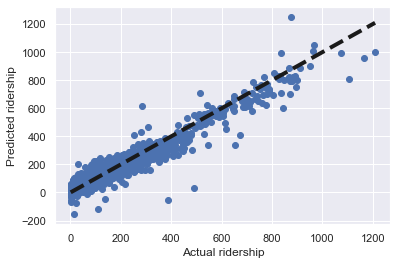

In [54]:
y = test_vald_labels
fig, ax = plt.subplots()
ax.scatter(y, pred_y)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Actual ridership')
ax.set_ylabel('Predicted ridership')
plt.show()

In [55]:
pd.set_option("display.max_rows", 100)
result = pd.DataFrame(test_vald_data)
result['actual_ridership'] = test_vald_labels.values
result['predicted_ridership'] = pred_y
result.tail(100)

,0,1,2,3,4,5,6,7,8,9,...,151,152,153,154,155,156,157,158,actual_ridership,predicted_ridership
6012,-0.012545,-0.279947,0.213952,-0.443065,-0.764574,-0.376343,0.0,-0.208876,-0.059916,0.069026,...,0.922973,-0.055164,-0.003838,-0.013295,0.889125,-0.883325,0.018804,-0.018804,29.0,55.710809
6013,0.478748,1.117569,-1.030341,0.073649,0.842108,-1.312448,0.0,0.177958,0.344775,0.112816,...,0.922973,-0.055164,-0.003838,-0.013295,-1.124701,1.132086,0.018804,-0.018804,59.0,51.118402
6014,-0.615495,-0.709952,-0.408194,-0.164834,-0.229013,-0.142316,0.0,0.564792,0.344775,0.112816,...,0.922973,-0.055164,-0.003838,-0.013295,0.889125,-0.883325,0.018804,-0.018804,52.0,69.086946
6015,0.690897,0.902566,0.391708,-0.888233,-0.688065,-0.532360,0.0,-0.982544,-0.869297,-0.018553,...,-1.083455,-0.055164,-0.003838,-0.013295,-1.124701,1.132086,0.018804,-0.018804,91.0,110.116651
6016,0.512245,1.117569,0.125074,-0.729245,1.224651,-0.844395,0.0,-0.982544,-0.869297,-0.018553,...,-1.083455,-0.055164,-0.003838,-0.013295,-1.124701,1.132086,0.018804,-0.018804,129.0,146.249091
6017,0.355925,0.472561,-0.674829,-0.951829,-0.994100,-1.312448,0.0,-0.982544,-0.869297,-0.062343,...,-1.083455,-0.055164,-0.003838,-0.013295,-1.124701,1.132086,0.018804,-0.018804,56.0,47.478896
6018,-0.101871,0.687564,-0.408194,-0.784891,0.153530,-0.922404,0.0,-0.595710,-0.464607,0.025236,...,-1.083455,-0.055164,-0.003838,-0.013295,0.889125,-0.883325,0.018804,-0.018804,106.0,78.418861
6019,-0.503838,-0.494949,0.213952,0.431374,0.383056,0.793789,0.0,0.177958,0.344775,0.112816,...,0.922973,-0.055164,-0.003838,-0.013295,0.889125,-0.883325,0.018804,-0.018804,33.0,37.527531
6020,0.646234,0.472561,0.747221,-1.166464,-1.835694,-0.688378,0.0,-1.369378,-1.273988,-0.062343,...,-1.083455,-0.055164,-0.003838,-0.013295,0.889125,-0.883325,0.018804,-0.018804,170.0,180.739693
6021,0.043284,-0.494949,0.747221,2.061009,1.530685,2.275956,0.0,0.951626,0.749465,0.200396,...,-1.083455,-0.055164,-0.003838,-0.013295,-1.124701,1.132086,0.018804,-0.018804,9.0,-12.842708


In [ ]:
# lgb.plot_importance(model, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance',
#                         xlabel='Feature importance', ylabel='Features', importance_type='gain', max_num_features=15);

**To be changed only after robust CV indicating the bettter score of 0.5365**

**Predict labels for test data and submit result**

In [ ]:
#Do predicitons bassis on model defined and trained earlier
xgtest = xgb.DMatrix(test_X)
predict_y = xgb_clf.predict(xgtest)

out_df = pd.DataFrame(predict_y)
out_df['listing_id'] = test_df.listing_id.values
out_df.columns = ['high','medium','low', 'listing_id']
cols = ['listing_id', 'high','medium', 'low']
out_df = out_df[cols]
out_df.to_csv('Desktop/MachineLearning/datasets/rental-listing/rentalListingResult.csv', header=True, index=False)